In [1]:
# Necessary imports

## Data loading, processing and for more
import pandas as pd
import numpy as np
#from imblearn.over_sampling import SMOTE

## Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# set seaborn style because it prettier
sns.set()

## Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

## Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [2]:
from mlflow import MlflowClient
from pprint import pprint

# Using the MLflow Client API

In [3]:
# Creation d'un client pour interagir avec le MLflow

client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

In [4]:
all_experiments = client.search_experiments()

print(all_experiments)

[<Experiment: artifact_location='mlflow-artifacts:/343155840015949158', creation_time=1725823163555, experiment_id='343155840015949158', last_update_time=1725823163555, lifecycle_stage='active', name='rf_Models', tags={'cours': 'MLOps',
 'mlflow.note.content': 'Prediction des defaut de paiement de credit. Cette '
                        'experience est une premier construction et évalution '
                        'du modéle.',
 'nom_du_projet': 'Prediction defaut de paiment',
 'project_quarter': 'Q3-2024',
 'team': 'dky'}>, <Experiment: artifact_location='mlflow-artifacts:/917315291385343525', creation_time=1725823163513, experiment_id='917315291385343525', last_update_time=1725823163513, lifecycle_stage='active', name='log_Models', tags={'cours': 'MLOps',
 'mlflow.note.content': 'Prediction des defaut de paiement de credit. Cette '
                        'experience est une premier construction et évalution '
                        'du modéle.',
 'nom_du_projet': 'Prediction defau

## Création d'une experience



In [7]:
import mlflow

# Description de l'expérience
experiment_description = (
    "Prediction des defaut de paiement de credit. "
    "Cette experience est une premier construction et évalution du modéle."
)

# Tags de l'expérience
experiment_tags = {
    "nom_du_projet": "Prediction defaut de paiment",
    "cours": "MLOps",
    "team": "dky",
    "project_quarter": "Q3-2024",
    "mlflow.note.content": experiment_description,
}
# Create the Experiment, providing a unique name
Logistic_experiment = client.create_experiment(
    name="log_Models", tags=experiment_tags
)
# Créer la deuxième expérience
rf_experiment = client.create_experiment(
    name="rf_Models",tags=experiment_tags 
)

RestException: RESOURCE_ALREADY_EXISTS: Experiment 'log_Models' already exists.

# 1- Importation des données

In [6]:
data= pd.read_csv("Data/loan_Data.csv")
data.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [8]:
data.shape

(10000, 8)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


In [10]:
data.isnull().sum()

customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,10000.0,4.974577e+06,2.293890e+06,1.000324e+06,2.977661e+06,4.989502e+06,6.967210e+06,8.999789e+06
credit_lines_outstanding,10000.0,1.461200e+00,1.743846e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,5.000000e+00
loan_amt_outstanding,10000.0,4.159677e+03,1.421399e+03,4.678397e+01,3.154235e+03,4.052377e+03,5.052898e+03,1.075068e+04
total_debt_outstanding,10000.0,8.718917e+03,6.627165e+03,3.165273e+01,4.199836e+03,6.732407e+03,1.127226e+04,4.368878e+04
income,10000.0,7.003990e+04,2.007221e+04,1.000000e+03,5.653987e+04,7.008583e+04,8.342917e+04,1.484122e+05
years_employed,10000.0,4.552800e+00,1.566862e+00,0.000000e+00,3.000000e+00,5.000000e+00,6.000000e+00,1.000000e+01
fico_score,10000.0,6.375577e+02,6.065791e+01,4.080000e+02,5.970000e+02,6.380000e+02,6.790000e+02,8.500000e+02
default,10000.0,1.851000e-01,3.883981e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


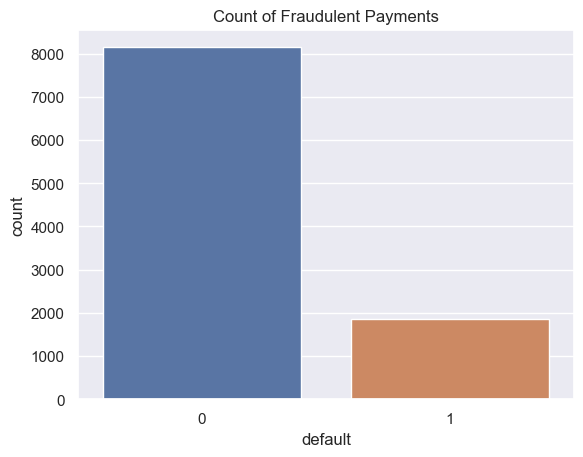

Number of normal examples:  8149
Number of fradulent examples:  1851


In [12]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = data.loc[data['default'] == 1] 
df_non_fraud = data.loc[data['default'] == 0]

sns.countplot(x="default",data=data)
plt.title("Count of Fraudulent Payments")
plt.show()
print("Number of normal examples: ",df_non_fraud.default.count())
print("Number of fradulent examples: ",df_fraud.default.count())
#print(data.fraud.value_counts()) # does the same thing above

In [13]:
data.groupby('years_employed')[['loan_amt_outstanding','total_debt_outstanding','income', 'fico_score']].mean()

,loan_amt_outstanding,total_debt_outstanding,income,fico_score
years_employed,,,,
0,4659.681572,14176.321909,67633.386003,589.562500
1,4658.612808,13606.051548,71382.026609,594.310976
2,4548.122434,10225.035812,70504.444278,621.517442
3,4377.788884,10146.232572,69724.314201,617.657969
4,4266.358479,9103.234532,70163.845025,631.572779
5,4079.695445,8005.944191,70116.519949,645.635198
6,3913.267816,7363.013223,69235.523576,647.304790
7,3853.935981,7267.437647,70801.053601,666.170181
8,3702.545458,7868.041891,71282.163580,671.290909


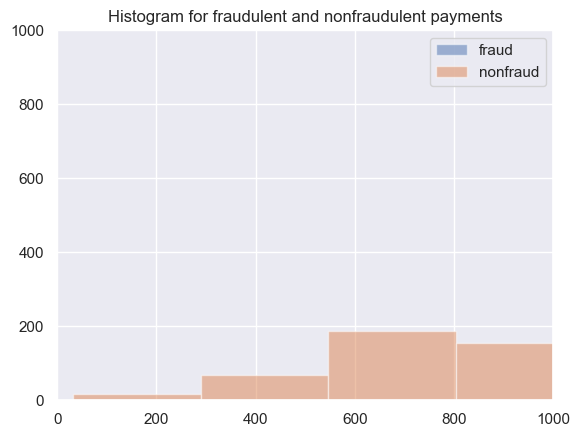

In [14]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.total_debt_outstanding, alpha=0.5, label='fraud',bins=100)
plt.hist(df_non_fraud.total_debt_outstanding, alpha=0.5, label='nonfraud',bins=100)
plt.title("Histogram for fraudulent and nonfraudulent payments")
plt.ylim(0,1000)
plt.xlim(0,1000)
plt.legend()
plt.show()

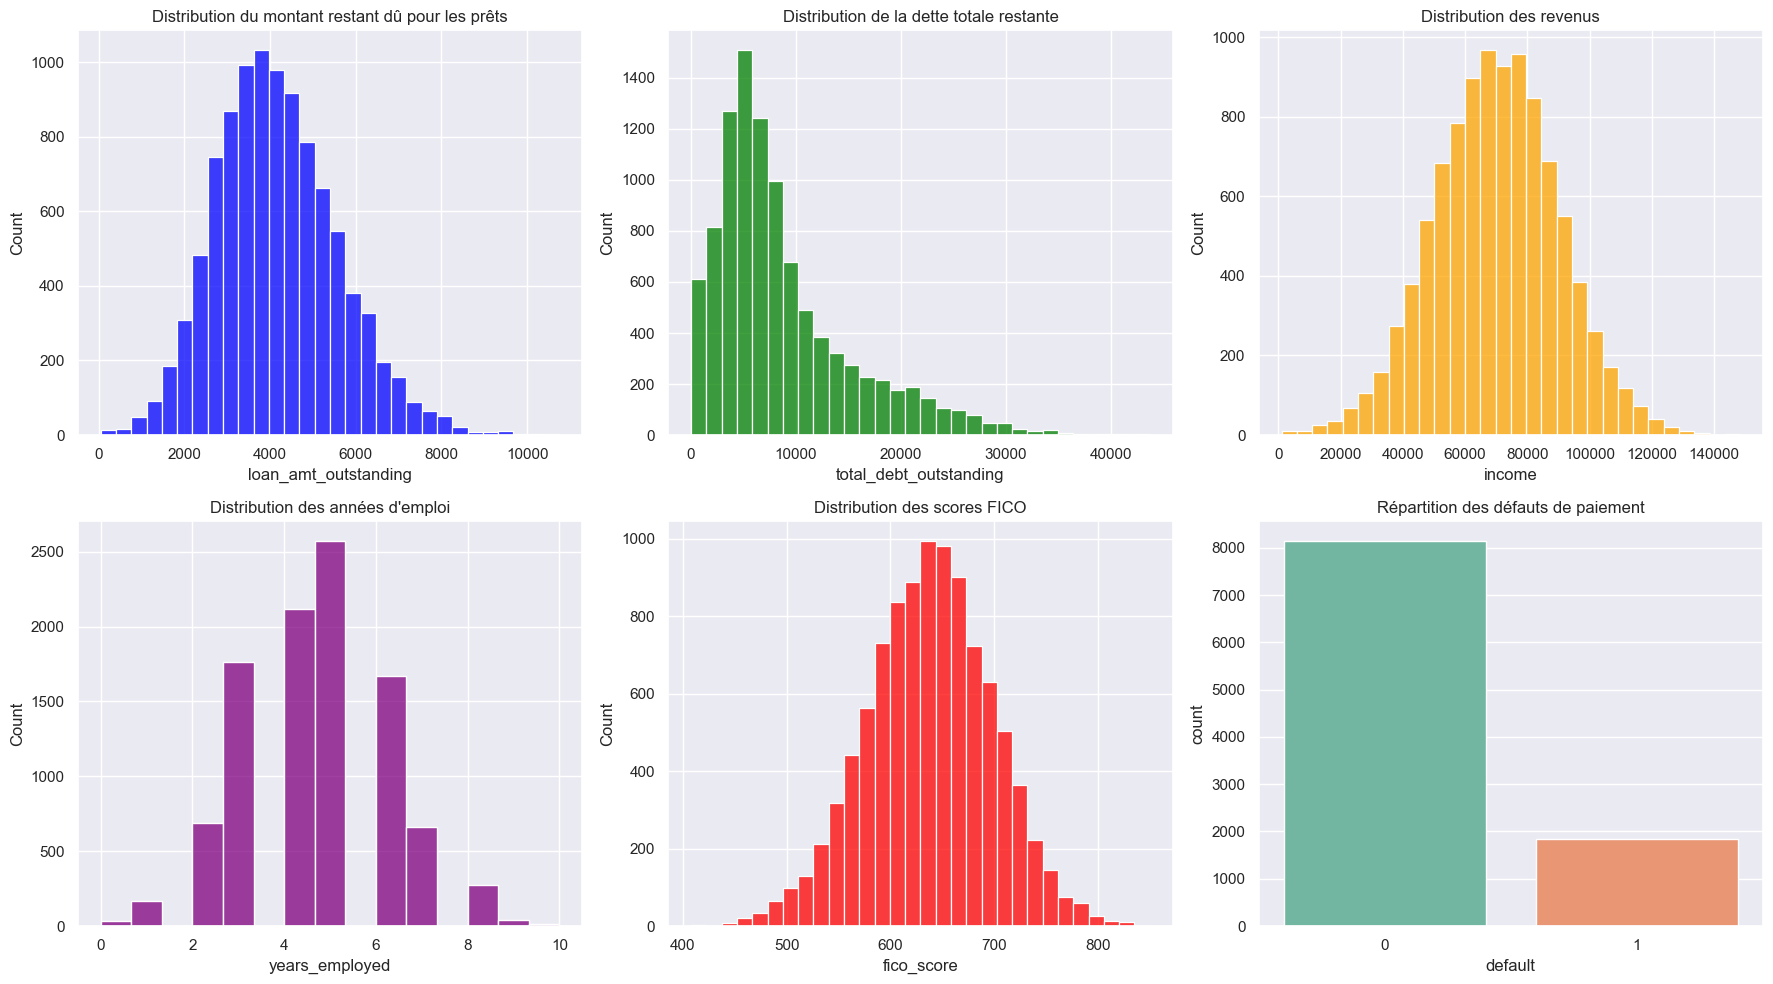

In [15]:
# 2. Visualisation des distributions
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Distribution du montant restant dû pour les prêts
sns.histplot(data['loan_amt_outstanding'], bins=30, ax=axs[0, 0], color='blue')
axs[0, 0].set_title('Distribution du montant restant dû pour les prêts')

# Distribution de la dette totale restante
sns.histplot(data['total_debt_outstanding'], bins=30, ax=axs[0, 1], color='green')
axs[0, 1].set_title('Distribution de la dette totale restante')

# Distribution des revenus
sns.histplot(data['income'], bins=30, ax=axs[0, 2], color='orange')
axs[0, 2].set_title('Distribution des revenus')

# Distribution des années d'emploi
sns.histplot(data['years_employed'], bins=15, ax=axs[1, 0], color='purple')
axs[1, 0].set_title('Distribution des années d\'emploi')

# Distribution des scores FICO
sns.histplot(data['fico_score'], bins=30, ax=axs[1, 1], color='red')
axs[1, 1].set_title('Distribution des scores FICO')

# Distribution des défauts de paiement
sns.countplot(x='default', data=data, ax=axs[1, 2], palette="Set2")
axs[1, 2].set_title('Répartition des défauts de paiement')

plt.tight_layout()
plt.show()


# 2 - PREPROCESSING

In [16]:
from scipy.stats import skew

# Calcul de l'asymétrie (skewness)
skewness = skew(data['total_debt_outstanding'])
print("L'asymétrie de 'total_debt_outstanding' est :", skewness)


L'asymétrie de 'total_debt_outstanding' est : 1.4138334239730668


# 3- Modéle

In [17]:
# Séparation des features et de la cible
X = data.drop(['default','customer_id'], axis=1)  # Remplacez 'target_column' par le nom de votre colonne cible
y = data['default']

In [18]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modele et tracking avec MLflow


In [19]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import mlflow
import mlflow.sklearn
import os
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

In [20]:
# This function call sets the global tracking URI for the current session.
# It’s a convenient way to configure the tracking server URI without creating a separate client instance.

mlflow.set_tracking_uri("http://127.0.0.1:8080")

### Modele Logistique

In [21]:
# Définition d'une expérience (Une expérience peut contenir plusieurs *runs*)
default_log_experiment = mlflow.set_experiment('log_Models')
# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "default_log_test"

# Define an artifact path that the model will be saved to.
artifact_path = "log_default"

In [22]:
## instance du modéle de regression Logistique
Model_Logistic = LogisticRegression()

# Entrainement du modéle
Model_Logistic.fit(X_train, y_train)

# Prediction des valeur
y_pred = Model_Logistic.predict(X_test)

In [23]:
# Calcule des métriques
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print(f"{Model_Logistic} Accuracy: {accuracy}")
print(f"{Model_Logistic} AUC: {auc}")

LogisticRegression() Accuracy: 0.9895
LogisticRegression() AUC: 0.9754981770615904


In [24]:
# Initiate the MLflow run context
with mlflow.start_run(run_name=run_name) as run:
    # Log the parameters used for the model fit
    #mlflow.log_params(params)

    # Log the error metrics that were calculated during validation
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("auc", auc)
    # Log an instance of the trained model for later use
    
    mlflow.sklearn.log_model(
            sk_model= Model_Logistic
            , 
            input_example=X_test[:5],  # Exemple d'entrée pour référence
            artifact_path=artifact_path  # Chemin où enregistrer le modèle
        )
    

c:\Users\nar6d\Desktop\MLOpsProject\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\nar6d\Desktop\MLOpsProject\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co

rapport de classification :                precision    recall  f1-score   support

           0       0.99      1.00      0.99      1652
           1       0.99      0.95      0.97       348

    accuracy                           0.99      2000
   macro avg       0.99      0.98      0.98      2000
weighted avg       0.99      0.99      0.99      2000



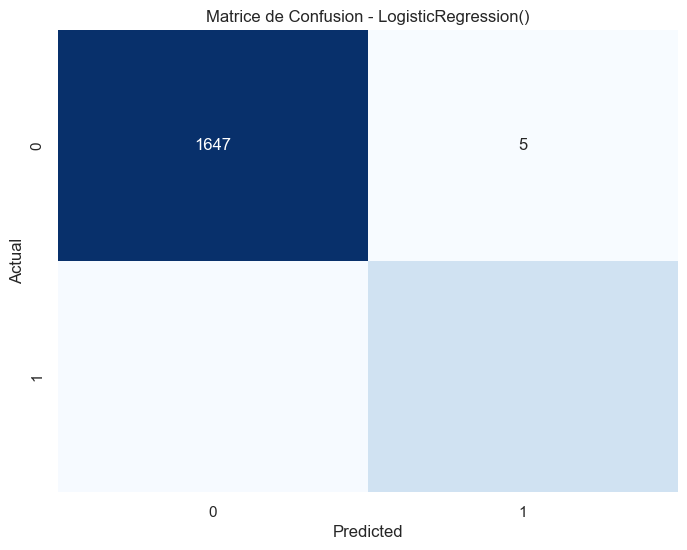

In [25]:
# Enregistrer le rapport de classification dans MLflow
class_report = classification_report(y_test, y_pred)
print("rapport de classification : ", class_report)
with open(f"classification_report_{Model_Logistic}.txt", "w") as f:
    f.write(class_report)
mlflow.log_artifact(f"classification_report_{Model_Logistic}.txt")
        
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Matrice de Confusion - {Model_Logistic}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
# Sauvegarder la matrice de confusion comme image
confusion_matrix_path = f"confusion_matrix_{Model_Logistic}.png"
plt.savefig(confusion_matrix_path)
plt.close()
        
# Enregistrer la matrice de confusion dans MLflow
mlflow.log_artifact(confusion_matrix_path)
        
# Supprimer les fichiers temporaires
os.remove(f"classification_report_{Model_Logistic}.txt")
os.remove(confusion_matrix_path)

### Random Forest

In [27]:
# Définition d'une expérience (Une expérience peut contenir plusieurs *runs*)
default_rf_experiment = mlflow.set_experiment('rf_Models')
# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "default_rf_test"

# Define an artifact path that the model will be saved to.
artifact_path = "rf_default"

In [28]:
## instance du modéle de regression Random Forest
params = {
    "n_estimators": 100,
    "max_depth": 6,
    "min_samples_split": 10,
    "min_samples_leaf": 4,
    "bootstrap": True,
    "oob_score": False,
    "random_state": 888,
}
Model_RandomForest = RandomForestClassifier(**params)

# Entrainement du modéle
Model_RandomForest.fit(X_train, y_train)

# Prediction des valeur
y_pred = Model_RandomForest.predict(X_test)

In [29]:
# Calcule des métriques
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print(f"{Model_RandomForest} Accuracy: {accuracy}")
print(f"{Model_RandomForest} AUC: {auc}")

RandomForestClassifier(max_depth=6, min_samples_leaf=4, min_samples_split=10,
                       random_state=888) Accuracy: 0.9915
RandomForestClassifier(max_depth=6, min_samples_leaf=4, min_samples_split=10,
                       random_state=888) AUC: 0.9835135398402494


In [30]:
# Initiate the MLflow run context
with mlflow.start_run(run_name=run_name) as run:
    # Log the parameters used for the model fit
    #mlflow.log_params(params)

    # Log the error metrics that were calculated during validation
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("auc", auc)
    # Log an instance of the trained model for later use
    
    mlflow.sklearn.log_model(
            sk_model=Model_RandomForest,
            input_example=X_test[:5],  # Exemple d'entrée pour référence
            artifact_path=artifact_path  # Chemin où enregistrer le modèle
        )
    

Exception: Run with UUID a37a4afa344d4cb3ba1b1fba893e7608 is already active. To start a new run, first end the current run with mlflow.end_run(). To start a nested run, call start_run with nested=True

Random Forest Accuracy: 0.995
Random Forest AUC: 0.9879004202499235


c:\Users\nar6d\Desktop\MLOpsProject\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\nar6d\Desktop\MLOpsProject\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co

rapport de classification :                precision    recall  f1-score   support

           0       1.00      1.00      1.00      1652
           1       0.99      0.98      0.99       348

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



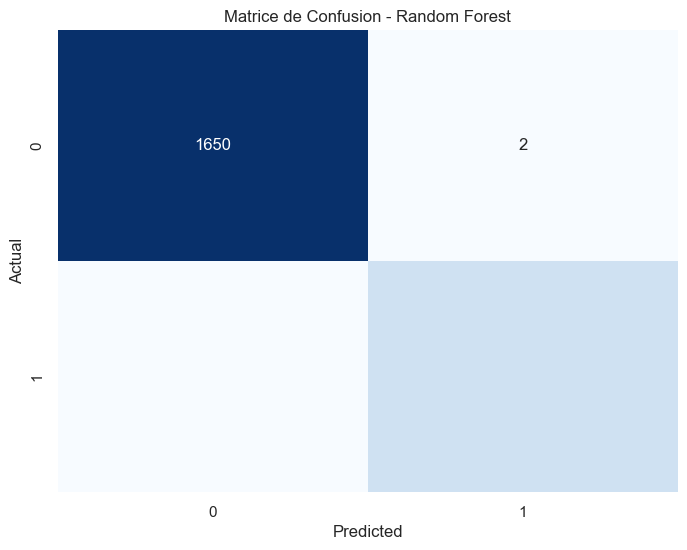

2024/09/08 09:36:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random Forest at: http://127.0.0.1:8080/#/experiments/482390419200420168/runs/27d5a871c64342bdb50cd80bb60a5d8a.
2024/09/08 09:36:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/482390419200420168.


In [25]:
# Enregistrer le rapport de classification dans MLflow
class_report = classification_report(y_test, y_pred)
print("rapport de classification : ", class_report)
with open(f"classification_report_{Model_RandomForest}.txt", "w") as f:
    f.write(class_report)
mlflow.log_artifact(f"classification_report_{Model_RandomForest}.txt")
        
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Matrice de Confusion - {Model_RandomForest}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
# Sauvegarder la matrice de confusion comme image
confusion_matrix_path = f"confusion_matrix_{Model_RandomForest}.png"
plt.savefig(confusion_matrix_path)
plt.close()
        
# Enregistrer la matrice de confusion dans MLflow
mlflow.log_artifact(confusion_matrix_path)
        
# Supprimer les fichiers temporaires
os.remove(f"classification_report_{Model_RandomForest}.txt")
os.remove(confusion_matrix_path)